# 04 - Collaborative Filtering

This notebook trains and evaluates collaborative filtering models:
- Train/test split (temporal)
- SVD matrix factorization (scipy)
- Gradient descent matrix factorization (custom)
- KNN-based models (user-based and item-based)
- Model evaluation and comparison
- Generate recommendations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import yaml
import pickle
import time

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Configuration and Data

In [2]:
# Load project config
project_root = Path.cwd().parent
config_path = project_root / 'config' / 'config.yaml'

with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Paths
processed_dir = project_root / config['data']['processed_dir']
features_dir = project_root / config['data']['features_dir']
models_dir = project_root / config['models']['save_dir']
models_dir.mkdir(parents=True, exist_ok=True)

# Model parameters
cf_config = config['models']['collaborative']
eval_config = config['evaluation']

print(f"CF Config:")
print(f"  n_factors: {cf_config['n_factors']}")
print(f"  n_epochs: {cf_config['n_epochs']}")
print(f"  lr_all: {cf_config['lr_all']}")
print(f"  reg_all: {cf_config['reg_all']}")
print(f"\nEvaluation Config:")
print(f"  test_size: {eval_config['test_size']}")
print(f"  temporal_split: {eval_config['temporal_split']}")
print(f"  k_values: {eval_config['k_values']}")

CF Config:
  n_factors: 100
  n_epochs: 20
  lr_all: 0.005
  reg_all: 0.02

Evaluation Config:
  test_size: 0.2
  temporal_split: True
  k_values: [5, 10, 20]


In [3]:
# Load cleaned ratings
print("Loading data...")
ratings = pd.read_parquet(processed_dir / 'ratings_cleaned.parquet')
movies = pd.read_parquet(features_dir / 'movie_features.parquet')

# Load ID mappings
with open(features_dir / 'id_mappings.pkl', 'rb') as f:
    mappings = pickle.load(f)

user_id_map = mappings['user_id_map']
movie_id_map = mappings['movie_id_map']
idx_to_user = mappings['idx_to_user']
idx_to_movie = mappings['idx_to_movie']

n_users = len(user_id_map)
n_movies = len(movie_id_map)

print(f"  Ratings: {len(ratings):,}")
print(f"  Users: {n_users:,}")
print(f"  Movies: {n_movies:,}")
print(f"  Rating range: {ratings['rating'].min()} - {ratings['rating'].max()}")

Loading data...
  Ratings: 24,914,810
  Users: 162,112
  Movies: 32,424
  Rating range: 0.5 - 5.0


## 2. Train/Test Split

In [4]:
print("Creating train/test split...")

if eval_config['temporal_split']:
    # Temporal split: use most recent ratings as test set
    ratings_sorted = ratings.sort_values('timestamp')
    split_idx = int(len(ratings_sorted) * (1 - eval_config['test_size']))
    
    train_df = ratings_sorted.iloc[:split_idx].copy()
    test_df = ratings_sorted.iloc[split_idx:].copy()
    
    print(f"  Temporal split (oldest {1-eval_config['test_size']:.0%} train, newest {eval_config['test_size']:.0%} test)")
else:
    from sklearn.model_selection import train_test_split
    train_df, test_df = train_test_split(
        ratings, 
        test_size=eval_config['test_size'],
        random_state=eval_config['random_state']
    )
    print(f"  Random split")

print(f"  Train set: {len(train_df):,} ratings")
print(f"  Test set: {len(test_df):,} ratings")
print(f"  Train users: {train_df['userId'].nunique():,}")
print(f"  Test users: {test_df['userId'].nunique():,}")

# Check for cold-start users/items in test set
cold_users = set(test_df['userId']) - set(train_df['userId'])
cold_movies = set(test_df['movieId']) - set(train_df['movieId'])
print(f"\n  Cold-start users in test: {len(cold_users):,}")
print(f"  Cold-start movies in test: {len(cold_movies):,}")

Creating train/test split...
  Temporal split (oldest 80% train, newest 20% test)
  Train set: 19,931,848 ratings
  Test set: 4,982,962 ratings
  Train users: 137,439
  Test users: 31,061

  Cold-start users in test: 24,673
  Cold-start movies in test: 6,364


In [5]:
# Build sparse train matrix
print("Building sparse train matrix...")

train_df['user_idx'] = train_df['userId'].map(user_id_map)
train_df['movie_idx'] = train_df['movieId'].map(movie_id_map)
test_df['user_idx'] = test_df['userId'].map(user_id_map)
test_df['movie_idx'] = test_df['movieId'].map(movie_id_map)

# Drop test entries with cold-start (unmapped) users/movies
test_df = test_df.dropna(subset=['user_idx', 'movie_idx'])
test_df['user_idx'] = test_df['user_idx'].astype(int)
test_df['movie_idx'] = test_df['movie_idx'].astype(int)

train_matrix = csr_matrix(
    (train_df['rating'].values, 
     (train_df['user_idx'].values, train_df['movie_idx'].values)),
    shape=(n_users, n_movies)
)

# Global mean rating
global_mean = train_df['rating'].mean()

print(f"  Train matrix shape: {train_matrix.shape}")
print(f"  Train matrix density: {train_matrix.nnz / (train_matrix.shape[0] * train_matrix.shape[1]):.4%}")
print(f"  Global mean rating: {global_mean:.4f}")

Building sparse train matrix...
  Train matrix shape: (162112, 32424)
  Train matrix density: 0.3792%
  Global mean rating: 3.5273


## 3. Evaluation Helpers

In [6]:
def evaluate_predictions(true_ratings, pred_ratings, model_name, k_values=None):
    """Evaluate a model's predictions on all metrics."""
    if k_values is None:
        k_values = eval_config['k_values']
    
    threshold = config['recommendations']['min_rating_threshold']
    
    print(f"\n{'='*50}")
    print(f"Evaluating: {model_name}")
    print(f"{'='*50}")

    # Clip predictions to valid range
    pred_clipped = np.clip(pred_ratings, 0.5, 5.0)

    # RMSE and MAE
    rmse = np.sqrt(mean_squared_error(true_ratings, pred_clipped))
    mae = mean_absolute_error(true_ratings, pred_clipped)
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")

    results = {'model': model_name, 'rmse': rmse, 'mae': mae}
    return results


def precision_recall_at_k(test_df, pred_func, k=10, threshold=4.0):
    """Compute precision and recall at k."""
    precisions = []
    recalls = []
    
    for user_id, group in test_df.groupby('userId'):
        true_relevant = set(group[group['rating'] >= threshold]['movieId'])
        if len(true_relevant) == 0:
            continue
            
        # Get predictions for this user's test items
        preds = []
        for _, row in group.iterrows():
            pred = pred_func(int(row['user_idx']), int(row['movie_idx']))
            preds.append((row['movieId'], pred))
        
        # Sort by predicted rating, take top k
        preds.sort(key=lambda x: x[1], reverse=True)
        top_k_items = set(item for item, _ in preds[:k])
        
        # Precision: fraction of top-k that are relevant
        n_relevant_in_k = len(top_k_items & true_relevant)
        precisions.append(n_relevant_in_k / k)
        recalls.append(n_relevant_in_k / len(true_relevant))
    
    return np.mean(precisions), np.mean(recalls)


def ndcg_at_k(test_df, pred_func, k=10):
    """Compute NDCG at k."""
    ndcgs = []
    
    for user_id, group in test_df.groupby('userId'):
        if len(group) < 2:
            continue
            
        preds = []
        for _, row in group.iterrows():
            pred = pred_func(int(row['user_idx']), int(row['movie_idx']))
            preds.append((row['rating'], pred))
        
        # Sort by predicted rating
        preds.sort(key=lambda x: x[1], reverse=True)
        top_k = preds[:k]
        
        # DCG
        dcg = sum(true_r / np.log2(i + 2) for i, (true_r, _) in enumerate(top_k))
        
        # Ideal DCG
        ideal = sorted(preds, key=lambda x: x[0], reverse=True)[:k]
        idcg = sum(true_r / np.log2(i + 2) for i, (true_r, _) in enumerate(ideal))
        
        if idcg > 0:
            ndcgs.append(dcg / idcg)
    
    return np.mean(ndcgs)


def full_evaluation(test_df, pred_func, model_name, k_values=None):
    """Run full evaluation including ranking metrics."""
    if k_values is None:
        k_values = eval_config['k_values']
    
    threshold = config['recommendations']['min_rating_threshold']
    
    # Rating prediction metrics
    true_ratings = test_df['rating'].values
    pred_ratings = np.array([
        pred_func(int(row['user_idx']), int(row['movie_idx']))
        for _, row in test_df.iterrows()
    ])
    
    results = evaluate_predictions(true_ratings, pred_ratings, model_name, k_values)
    
    # Sample subset for ranking metrics (full set is too slow)
    sample_users = test_df['userId'].unique()
    if len(sample_users) > 5000:
        np.random.seed(eval_config['random_state'])
        sample_users = np.random.choice(sample_users, 5000, replace=False)
        test_sample = test_df[test_df['userId'].isin(sample_users)]
        print(f"  (Using {len(sample_users):,} sampled users for ranking metrics)")
    else:
        test_sample = test_df
    
    # Ranking metrics
    for k in k_values:
        prec, rec = precision_recall_at_k(test_sample, pred_func, k=k, threshold=threshold)
        ndcg = ndcg_at_k(test_sample, pred_func, k=k)
        
        print(f"  P@{k}: {prec:.4f}  R@{k}: {rec:.4f}  NDCG@{k}: {ndcg:.4f}")
        results[f'precision@{k}'] = prec
        results[f'recall@{k}'] = rec
        results[f'ndcg@{k}'] = ndcg
    
    return results


print("Evaluation helpers defined.")

Evaluation helpers defined.


## 4. Baseline Model (Global Mean)

In [7]:
print("Evaluating baseline model (global mean)...")

start_time = time.time()

# Compute user and movie biases
user_means = train_df.groupby('user_idx')['rating'].mean()
movie_means = train_df.groupby('movie_idx')['rating'].mean()

def baseline_predict(user_idx, movie_idx):
    """Predict using global mean + user bias + movie bias."""
    user_bias = user_means.get(user_idx, global_mean) - global_mean
    movie_bias = movie_means.get(movie_idx, global_mean) - global_mean
    return global_mean + user_bias + movie_bias

train_time = time.time() - start_time
print(f"  Training time: {train_time:.1f}s")

# Quick evaluation (RMSE/MAE only for speed)
pred_ratings = np.array([
    baseline_predict(int(row['user_idx']), int(row['movie_idx']))
    for _, row in test_df.iterrows()
])

baseline_results = evaluate_predictions(test_df['rating'].values, pred_ratings, 'Baseline (Mean+Bias)')
baseline_results['train_time'] = train_time

Evaluating baseline model (global mean)...
  Training time: 0.4s

Evaluating: Baseline (Mean+Bias)
  RMSE: 1.0060
  MAE:  0.7672


## 5. SVD Model (Truncated SVD via scipy)

In [8]:
print(f"Training SVD model (k={cf_config['n_factors']} factors)...")

start_time = time.time()

from scipy.sparse import coo_matrix

# Compute user and item biases directly from sparse matrix (no .toarray() needed)
user_rating_sums = np.array(train_matrix.sum(axis=1)).flatten()
user_rating_counts = np.array((train_matrix > 0).sum(axis=1)).flatten()
user_bias = np.where(user_rating_counts > 0,
                     user_rating_sums / user_rating_counts - global_mean, 0.0)

item_rating_sums = np.array(train_matrix.sum(axis=0)).flatten()
item_rating_counts = np.array((train_matrix > 0).sum(axis=0)).flatten()
item_bias = np.where(item_rating_counts > 0,
                     item_rating_sums / item_rating_counts - global_mean, 0.0)

# Subtract biases from observed entries only - keeps the matrix sparse
train_coo = train_matrix.tocoo()
corrected_data = (train_coo.data
                  - global_mean
                  - user_bias[train_coo.row]
                  - item_bias[train_coo.col])

train_corrected = csr_matrix(
    (corrected_data, (train_coo.row, train_coo.col)),
    shape=train_matrix.shape
)

print(f"  Biases computed. Running sparse SVD (no dense conversion)...")

# Truncated SVD on the sparse matrix
U, sigma, Vt = svds(train_corrected, k=cf_config['n_factors'])

# Precompute U * sigma for fast batch prediction
U_sigma = U * sigma  # shape: (n_users, k)

train_time = time.time() - start_time
print(f"  Training time: {train_time:.1f}s")
print(f"  U shape: {U.shape}, sigma shape: {sigma.shape}, Vt shape: {Vt.shape}")
print(f"  Memory: U_sigma={U_sigma.nbytes/1024**2:.1f} MB, Vt={Vt.nbytes/1024**2:.1f} MB")

Training SVD model (k=100 factors)...
  Biases computed. Running sparse SVD (no dense conversion)...
  Training time: 14.2s
  U shape: (162112, 100), sigma shape: (100,), Vt shape: (100, 32424)
  Memory: U_sigma=123.7 MB, Vt=24.7 MB


In [9]:
# Evaluate SVD - vectorized batch prediction, no dense matrix materialized
def svd_predict_batch(user_indices, movie_indices):
    return np.clip(
        global_mean
        + user_bias[user_indices]
        + item_bias[movie_indices]
        + np.sum(U_sigma[user_indices] * Vt.T[movie_indices], axis=1),
        0.5, 5.0
    )

pred_ratings = svd_predict_batch(
    test_df['user_idx'].values,
    test_df['movie_idx'].values
)
svd_results = evaluate_predictions(test_df['rating'].values, pred_ratings, 'SVD')
svd_results['train_time'] = train_time


Evaluating: SVD
  RMSE: 1.0042
  MAE:  0.7654


## 6. Gradient Descent Matrix Factorization (SGD-MF)

In [10]:
class SGDMatrixFactorization:
    """Matrix Factorization using Stochastic Gradient Descent."""
    
    def __init__(self, n_users, n_items, n_factors=100, lr=0.005, reg=0.02, 
                 n_epochs=20, random_state=42):
        self.n_factors = n_factors
        self.lr = lr
        self.reg = reg
        self.n_epochs = n_epochs
        
        rng = np.random.RandomState(random_state)
        self.user_factors = rng.normal(0, 0.1, (n_users, n_factors))
        self.item_factors = rng.normal(0, 0.1, (n_items, n_factors))
        self.user_biases = np.zeros(n_users)
        self.item_biases = np.zeros(n_items)
        self.global_mean = 0
    
    def fit(self, train_df):
        self.global_mean = train_df['rating'].mean()
        
        users = train_df['user_idx'].values
        items = train_df['movie_idx'].values
        ratings = train_df['rating'].values
        
        for epoch in range(self.n_epochs):
            # Shuffle training data
            indices = np.random.permutation(len(ratings))
            
            total_loss = 0
            for idx in indices:
                u, i, r = users[idx], items[idx], ratings[idx]
                
                # Predict
                pred = (self.global_mean + self.user_biases[u] + 
                        self.item_biases[i] + self.user_factors[u] @ self.item_factors[i])
                
                # Error
                err = r - pred
                total_loss += err ** 2
                
                # Update biases
                self.user_biases[u] += self.lr * (err - self.reg * self.user_biases[u])
                self.item_biases[i] += self.lr * (err - self.reg * self.item_biases[i])
                
                # Update factors
                user_f = self.user_factors[u].copy()
                self.user_factors[u] += self.lr * (err * self.item_factors[i] - self.reg * self.user_factors[u])
                self.item_factors[i] += self.lr * (err * user_f - self.reg * self.item_factors[i])
            
            rmse = np.sqrt(total_loss / len(ratings))
            print(f"    Epoch {epoch+1}/{self.n_epochs} - Train RMSE: {rmse:.4f}")
    
    def predict(self, user_idx, item_idx):
        pred = (self.global_mean + self.user_biases[user_idx] + 
                self.item_biases[item_idx] + 
                self.user_factors[user_idx] @ self.item_factors[item_idx])
        return np.clip(pred, 0.5, 5.0)
    
    def predict_batch(self, user_indices, item_indices):
        preds = (self.global_mean + 
                 self.user_biases[user_indices] + 
                 self.item_biases[item_indices] + 
                 np.sum(self.user_factors[user_indices] * self.item_factors[item_indices], axis=1))
        return np.clip(preds, 0.5, 5.0)


print("SGD Matrix Factorization class defined.")

SGD Matrix Factorization class defined.


In [11]:
print(f"Training SGD-MF model...")
print(f"  Parameters: n_factors={cf_config['n_factors']}, n_epochs={cf_config['n_epochs']}, "
      f"lr={cf_config['lr_all']}, reg={cf_config['reg_all']}")

start_time = time.time()

sgd_model = SGDMatrixFactorization(
    n_users=n_users,
    n_items=n_movies,
    n_factors=cf_config['n_factors'],
    lr=cf_config['lr_all'],
    reg=cf_config['reg_all'],
    n_epochs=cf_config['n_epochs'],
    random_state=cf_config['random_state']
)
sgd_model.fit(train_df)

train_time_sgd = time.time() - start_time
print(f"\n  Training time: {train_time_sgd:.1f}s ({train_time_sgd/60:.1f} min)")

Training SGD-MF model...
  Parameters: n_factors=100, n_epochs=20, lr=0.005, reg=0.02
    Epoch 1/20 - Train RMSE: 0.9033
    Epoch 2/20 - Train RMSE: 0.8670
    Epoch 3/20 - Train RMSE: 0.8527
    Epoch 4/20 - Train RMSE: 0.8367
    Epoch 5/20 - Train RMSE: 0.8220
    Epoch 6/20 - Train RMSE: 0.8080
    Epoch 7/20 - Train RMSE: 0.7949
    Epoch 8/20 - Train RMSE: 0.7829
    Epoch 9/20 - Train RMSE: 0.7717
    Epoch 10/20 - Train RMSE: 0.7614
    Epoch 11/20 - Train RMSE: 0.7518
    Epoch 12/20 - Train RMSE: 0.7427
    Epoch 13/20 - Train RMSE: 0.7341
    Epoch 14/20 - Train RMSE: 0.7258
    Epoch 15/20 - Train RMSE: 0.7180
    Epoch 16/20 - Train RMSE: 0.7104
    Epoch 17/20 - Train RMSE: 0.7031
    Epoch 18/20 - Train RMSE: 0.6961
    Epoch 19/20 - Train RMSE: 0.6894
    Epoch 20/20 - Train RMSE: 0.6829

  Training time: 3237.7s (54.0 min)


In [12]:
# Evaluate SGD-MF
pred_ratings = sgd_model.predict_batch(
    test_df['user_idx'].values, 
    test_df['movie_idx'].values
)

sgd_results = evaluate_predictions(test_df['rating'].values, pred_ratings, 'SGD-MF')
sgd_results['train_time'] = train_time_sgd


Evaluating: SGD-MF
  RMSE: 1.0019
  MAE:  0.7678


## 7. KNN Item-Based Model

In [13]:
print("Training KNN Item-Based model...")

start_time = time.time()

# Transpose: items as rows for item-based CF
item_matrix = train_matrix.T.tocsr()

knn_item = NearestNeighbors(n_neighbors=41, metric='cosine', algorithm='brute', n_jobs=-1)
knn_item.fit(item_matrix)

train_time_knn_item = time.time() - start_time
print(f"  Training time: {train_time_knn_item:.1f}s")
print(f"  Item matrix shape: {item_matrix.shape}")

Training KNN Item-Based model...
  Training time: 0.3s
  Item matrix shape: (32424, 162112)


In [14]:
# KNN Item-Based prediction
def knn_item_predict(user_idx, movie_idx):
    """Predict rating using item-based KNN."""
    # Find similar items
    distances, indices = knn_item.kneighbors(item_matrix[movie_idx], n_neighbors=41)
    
    # Skip the item itself (first neighbor)
    sim_scores = 1 - distances.flatten()[1:]  # Convert distance to similarity
    sim_items = indices.flatten()[1:]
    
    # Get user's ratings for similar items
    user_row = train_matrix[user_idx].toarray().flatten()
    user_ratings = user_row[sim_items]
    
    # Weighted average of ratings for items the user has rated
    rated_mask = user_ratings > 0
    if rated_mask.sum() == 0:
        return global_mean
    
    weights = sim_scores[rated_mask]
    rated = user_ratings[rated_mask]
    
    if weights.sum() == 0:
        return global_mean
    
    return np.average(rated, weights=np.abs(weights))


# Evaluate on test set (sample for speed)
print("Evaluating KNN Item-Based (sampling test set for speed)...")

np.random.seed(eval_config['random_state'])
sample_size = min(100_000, len(test_df))
test_sample = test_df.sample(n=sample_size, random_state=eval_config['random_state'])

pred_ratings = []
for i, (_, row) in enumerate(test_sample.iterrows()):
    pred = knn_item_predict(int(row['user_idx']), int(row['movie_idx']))
    pred_ratings.append(pred)
    if (i + 1) % 20000 == 0:
        print(f"  Progress: {i+1:,}/{sample_size:,}")

pred_ratings = np.array(pred_ratings)

knn_item_results = evaluate_predictions(
    test_sample['rating'].values, pred_ratings, 'KNN Item-Based'
)
knn_item_results['train_time'] = train_time_knn_item

Evaluating KNN Item-Based (sampling test set for speed)...
  Progress: 20,000/100,000
  Progress: 40,000/100,000
  Progress: 60,000/100,000
  Progress: 80,000/100,000
  Progress: 100,000/100,000

Evaluating: KNN Item-Based
  RMSE: 1.0628
  MAE:  0.8240


## 8. KNN User-Based Model

In [15]:
print("Training KNN User-Based model...")

start_time = time.time()

knn_user = NearestNeighbors(n_neighbors=41, metric='cosine', algorithm='brute', n_jobs=-1)
knn_user.fit(train_matrix)

train_time_knn_user = time.time() - start_time
print(f"  Training time: {train_time_knn_user:.1f}s")
print(f"  User matrix shape: {train_matrix.shape}")

Training KNN User-Based model...
  Training time: 0.0s
  User matrix shape: (162112, 32424)


In [16]:
# KNN User-Based prediction
def knn_user_predict(user_idx, movie_idx):
    """Predict rating using user-based KNN."""
    # Find similar users
    distances, indices = knn_user.kneighbors(train_matrix[user_idx], n_neighbors=41)
    
    sim_scores = 1 - distances.flatten()[1:]
    sim_users = indices.flatten()[1:]
    
    # Get similar users' ratings for this movie
    movie_col = train_matrix[:, movie_idx].toarray().flatten()
    neighbor_ratings = movie_col[sim_users]
    
    # Weighted average
    rated_mask = neighbor_ratings > 0
    if rated_mask.sum() == 0:
        return global_mean
    
    weights = sim_scores[rated_mask]
    rated = neighbor_ratings[rated_mask]
    
    if weights.sum() == 0:
        return global_mean
    
    return np.average(rated, weights=np.abs(weights))


# Evaluate on test set (sample for speed)
print("Evaluating KNN User-Based (sampling test set for speed)...")

test_sample = test_df.sample(n=sample_size, random_state=eval_config['random_state'])

pred_ratings = []
for i, (_, row) in enumerate(test_sample.iterrows()):
    pred = knn_user_predict(int(row['user_idx']), int(row['movie_idx']))
    pred_ratings.append(pred)
    if (i + 1) % 20000 == 0:
        print(f"  Progress: {i+1:,}/{sample_size:,}")

pred_ratings = np.array(pred_ratings)

knn_user_results = evaluate_predictions(
    test_sample['rating'].values, pred_ratings, 'KNN User-Based'
)
knn_user_results['train_time'] = train_time_knn_user

Evaluating KNN User-Based (sampling test set for speed)...
  Progress: 20,000/100,000
  Progress: 40,000/100,000
  Progress: 60,000/100,000
  Progress: 80,000/100,000
  Progress: 100,000/100,000

Evaluating: KNN User-Based
  RMSE: 1.0700
  MAE:  0.8316


## 9. Model Comparison

In [17]:
# Collect all results
all_results = pd.DataFrame([
    baseline_results,
    svd_results,
    sgd_results,
    knn_item_results,
    knn_user_results
])

all_results = all_results.set_index('model')

print("=" * 70)
print("MODEL COMPARISON")
print("=" * 70)
print(all_results.to_string())

MODEL COMPARISON
                          rmse       mae   train_time
model                                                
Baseline (Mean+Bias)  1.006033  0.767201     0.438192
SVD                   1.004236  0.765421    14.165366
SGD-MF                1.001906  0.767802  3237.713471
KNN Item-Based        1.062782  0.823979     0.283041
KNN User-Based        1.069953  0.831554     0.039007


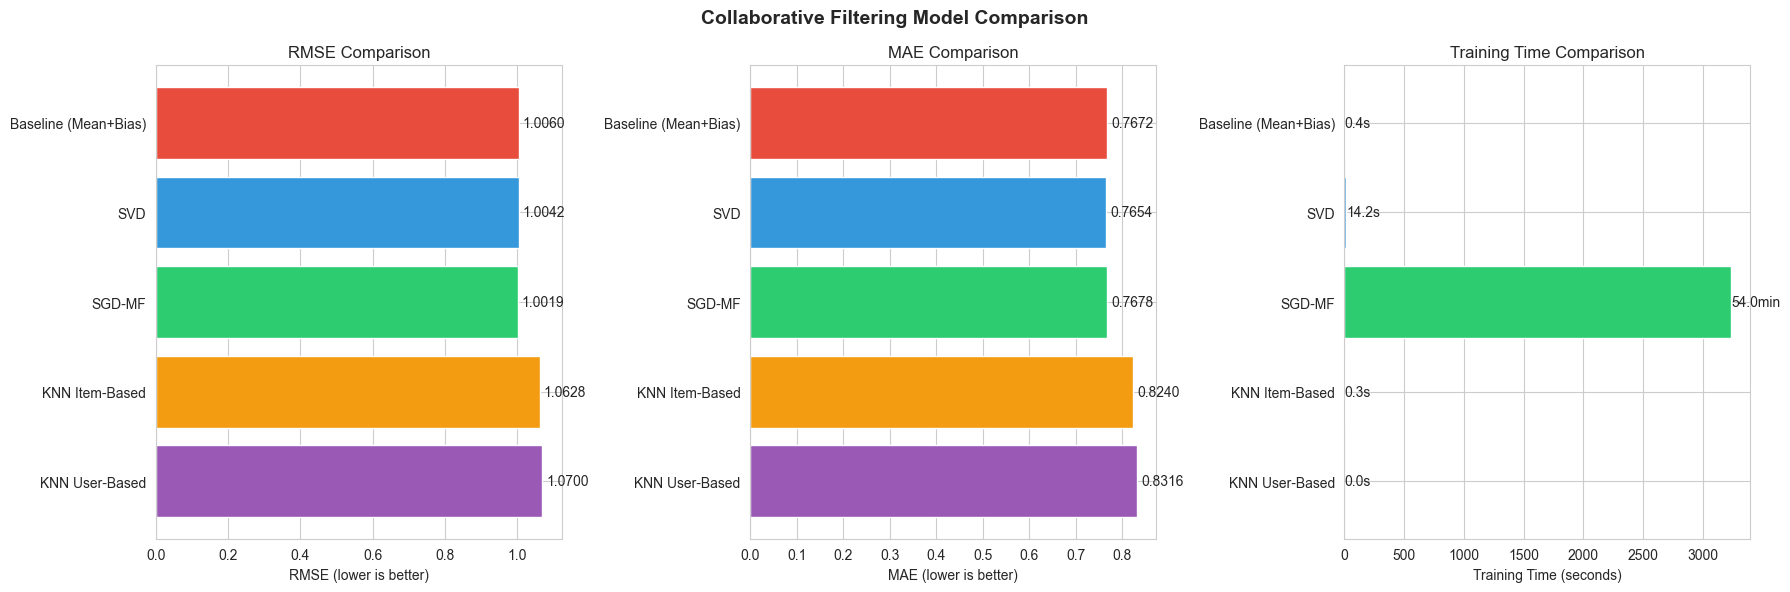

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

models = all_results.index.tolist()
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6']

# RMSE comparison
axes[0].barh(models, all_results['rmse'], color=colors)
axes[0].set_xlabel('RMSE (lower is better)')
axes[0].set_title('RMSE Comparison')
axes[0].invert_yaxis()
for i, v in enumerate(all_results['rmse']):
    axes[0].text(v + 0.01, i, f'{v:.4f}', va='center')

# MAE comparison
axes[1].barh(models, all_results['mae'], color=colors)
axes[1].set_xlabel('MAE (lower is better)')
axes[1].set_title('MAE Comparison')
axes[1].invert_yaxis()
for i, v in enumerate(all_results['mae']):
    axes[1].text(v + 0.01, i, f'{v:.4f}', va='center')

# Training time comparison
axes[2].barh(models, all_results['train_time'], color=colors)
axes[2].set_xlabel('Training Time (seconds)')
axes[2].set_title('Training Time Comparison')
axes[2].invert_yaxis()
for i, v in enumerate(all_results['train_time']):
    label = f'{v:.1f}s' if v < 60 else f'{v/60:.1f}min'
    axes[2].text(v + 0.5, i, label, va='center')

plt.suptitle('Collaborative Filtering Model Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 10. Select Best Model

In [19]:
# Select best model based on RMSE (excluding baseline)
model_results_no_baseline = all_results.drop('Baseline (Mean+Bias)', errors='ignore')
best_model_name = model_results_no_baseline['rmse'].idxmin()

print(f"Best model by RMSE: {best_model_name}")
print(f"  RMSE: {model_results_no_baseline.loc[best_model_name, 'rmse']:.4f}")
print(f"  MAE: {model_results_no_baseline.loc[best_model_name, 'mae']:.4f}")

Best model by RMSE: SGD-MF
  RMSE: 1.0019
  MAE: 0.7678


## 11. Generate Sample Recommendations

In [20]:
def get_user_recommendations(user_id, n=10):
    """Get top-N movie recommendations using the SGD-MF model."""
    user_idx = user_id_map.get(user_id)
    if user_idx is None:
        print(f"User {user_id} not found.")
        return pd.DataFrame()
    
    # Movies the user has already rated
    rated_movies = set(train_df[train_df['userId'] == user_id]['movieId'])
    
    # Predict for all unrated movies
    predictions = []
    for movie_id, movie_idx in movie_id_map.items():
        if movie_id not in rated_movies:
            pred = sgd_model.predict(user_idx, movie_idx)
            predictions.append((movie_id, pred))
    
    # Sort by predicted rating
    predictions.sort(key=lambda x: x[1], reverse=True)
    top_n = predictions[:n]
    
    # Get movie details
    recs = []
    for movie_id, est_rating in top_n:
        movie_info = movies[movies['movieId'] == movie_id]
        if len(movie_info) > 0:
            movie_info = movie_info.iloc[0]
            recs.append({
                'movieId': movie_id,
                'title': movie_info['title'],
                'genres': movie_info['genres'],
                'predicted_rating': round(est_rating, 2),
                'avg_rating': round(movie_info.get('avg_rating', 0), 2),
                'num_ratings': int(movie_info.get('num_ratings', 0))
            })
    
    return pd.DataFrame(recs)

print("Recommendation function defined.")

Recommendation function defined.


In [21]:
# Generate recommendations for sample users
top_n = config['recommendations']['default_top_n']
sample_users = train_df['userId'].value_counts().head(3).index.tolist()

for user_id in sample_users:
    user_ratings = ratings[ratings['userId'] == user_id]
    user_top = user_ratings.nlargest(5, 'rating').merge(movies[['movieId', 'title']], on='movieId')
    
    print(f"\n{'='*70}")
    print(f"User {user_id} (rated {len(user_ratings)} movies, avg rating: {user_ratings['rating'].mean():.2f})")
    print(f"{'='*70}")
    
    print(f"\nTop rated movies:")
    for _, row in user_top.iterrows():
        print(f"  {row['rating']:.1f} - {row['title']}")
    
    print(f"\nTop {top_n} recommendations (SGD-MF):")
    recs = get_user_recommendations(user_id, n=top_n)
    for i, row in recs.iterrows():
        print(f"  {row['predicted_rating']:.2f} - {row['title']} ({row['genres']})")


User 72315 (rated 22213 movies, avg rating: 3.14)

Top rated movies:
  5.0 - Hate (Haine, La) (1995)
  5.0 - From the Journals of Jean Seberg (1995)
  5.0 - Before Sunrise (1995)
  5.0 - Three Colors: Red (Trois couleurs: Rouge) (1994)
  5.0 - Three Colors: Blue (Trois couleurs: Bleu) (1993)

Top 20 recommendations (SGD-MF):
  4.57 - Civil War, The (1990) (Documentary|War)
  4.47 - Connections (1978) (Documentary)
  4.47 - Alone in the Wilderness (2004) (Documentary)
  4.33 - John Mulaney: New In Town (2012) (Comedy)
  4.29 - Wild China (2008) (Documentary)
  4.22 - The War (2007) (Documentary|War)
  4.21 - Richard Pryor: Live in Concert (1979) (Comedy|Documentary)
  4.20 - John Adams (2008) (Drama)
  4.17 - Maltese Falcon, The (a.k.a. Dangerous Female) (1931) (Mystery)
  4.16 - No Direction Home: Bob Dylan (2005) (Documentary)
  4.16 - Gate of Heavenly Peace, The (1995) (Documentary)
  4.15 - Bleak House (2005) (Drama)
  4.13 - The Blue Planet (2001) (Documentary)
  4.13 - King of Ma

## 12. Save Models and Results

In [22]:
print("Saving models and results...\n")

# Save SGD-MF model
sgd_model_path = models_dir / 'sgd_mf_model.pkl'
with open(sgd_model_path, 'wb') as f:
    pickle.dump(sgd_model, f)
print(f"  Saved SGD-MF model to: {sgd_model_path}")
print(f"  Size: {sgd_model_path.stat().st_size / 1024**2:.1f} MB")

# Save SVD components (compact factor matrices only)
svd_components = {
    'U_sigma': U_sigma, 'Vt': Vt,
    'user_bias': user_bias,
    'item_bias': item_bias,
    'global_mean': global_mean
}
svd_path = models_dir / 'svd_components.pkl'
with open(svd_path, 'wb') as f:
    pickle.dump(svd_components, f)
print(f"\n  Saved SVD components to: {svd_path}")
print(f"  Size: {svd_path.stat().st_size / 1024**2:.1f} MB")

# Save evaluation results
results_path = models_dir / 'cf_evaluation_results.csv'
all_results.to_csv(results_path)
print(f"\n  Saved evaluation results to: {results_path}")

# Save train/test split info
split_info = {
    'split_type': 'temporal' if eval_config['temporal_split'] else 'random',
    'test_size': eval_config['test_size'],
    'train_ratings': len(train_df),
    'test_ratings': len(test_df),
    'best_model': best_model_name,
    'best_rmse': float(all_results.loc[best_model_name, 'rmse']),
    'best_mae': float(all_results.loc[best_model_name, 'mae'])
}

split_info_path = models_dir / 'cf_split_info.yaml'
with open(split_info_path, 'w') as f:
    yaml.dump(split_info, f, default_flow_style=False)
print(f"\n  Saved split info to: {split_info_path}")

print("\n" + "=" * 60)
print("ALL MODELS AND RESULTS SAVED!")
print("=" * 60)

Saving models and results...

  Saved SGD-MF model to: c:\Users\ololi\StudioProjects\movie-recommender\src\models\sgd_mf_model.pkl
  Size: 149.9 MB

  Saved SVD components to: c:\Users\ololi\StudioProjects\movie-recommender\src\models\svd_components.pkl
  Size: 149.9 MB

  Saved evaluation results to: c:\Users\ololi\StudioProjects\movie-recommender\src\models\cf_evaluation_results.csv

  Saved split info to: c:\Users\ololi\StudioProjects\movie-recommender\src\models\cf_split_info.yaml

ALL MODELS AND RESULTS SAVED!
